# **<center>Action Recognition from Videos using Recurrent Neural Networks</center>**

The objective of this exercise is to classify the type of action being executed in videos.

The UCF101 dataset will be used. Four classes: Basketball, Diving, Golf Swing, Skiing

* 140 videos for training. Approximately 40 videos for each class. Each video has 40 frames.

* 400 videos for testing. Approximately 100 videos for each class. Each video has 40 frames.





# **<center>Network Architecture</center>**



Each frame is passed to a CNN encoder. The result is flattened and passed to the RNN network. We take the last output of the sequence to produce the final classification result

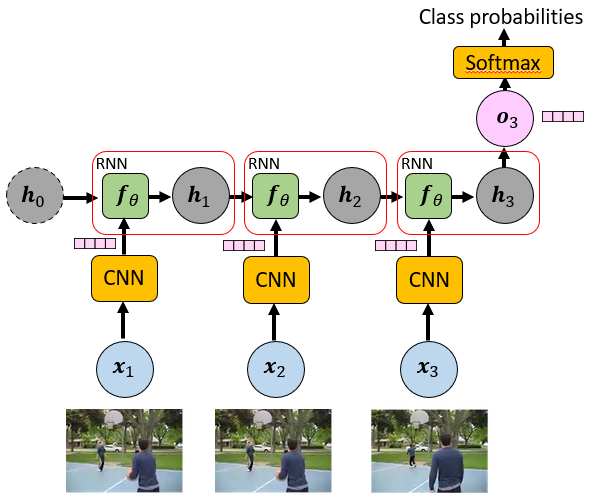

Each frame is passed to a pre-trained, frozen VGG16 encoder. Global Average Pooling (GAP) is applied to the resulting sequence of feature maps, producing a sequence of feature vectors. The sequence is passed to a many-to-one LSTM, followed by a dense network with softmax activation for the final class probabilities

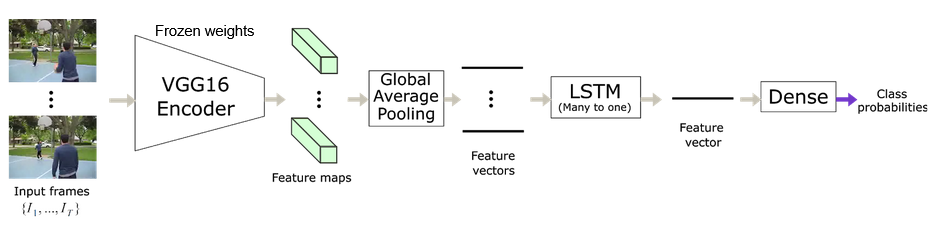

## **<center>VGG Encoder</center>**

The VGG16 encoder is used with ImageNet pre-trained weights.

The encoder is **indepentently** applied to **each frame** in the input video.

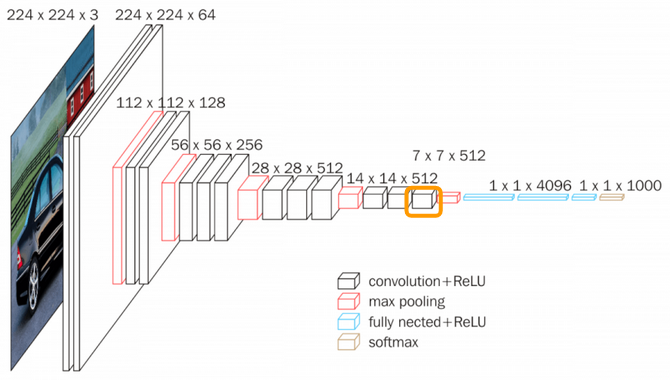

## **<center>Global average pooling (GAP)</center>**

The encoder output is passed to a GAP layer. It obtains the spatial global average value for each channel in the feature map.

GAP is **independently applied** to **each feature map** in the sequence.

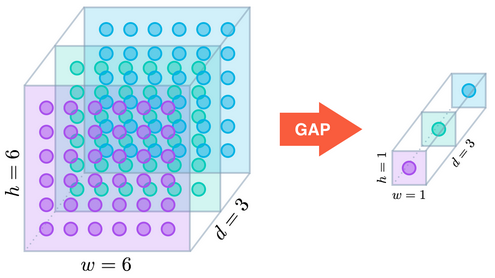

## **<center>Many-to-one LSTM (N-to-1)</center>**

The sequence of feature vectors is passed to a LSTM. We only take the latest element in the resulting sequence. Then we apply a Dense layer with softmax activation function for the final class probabilities

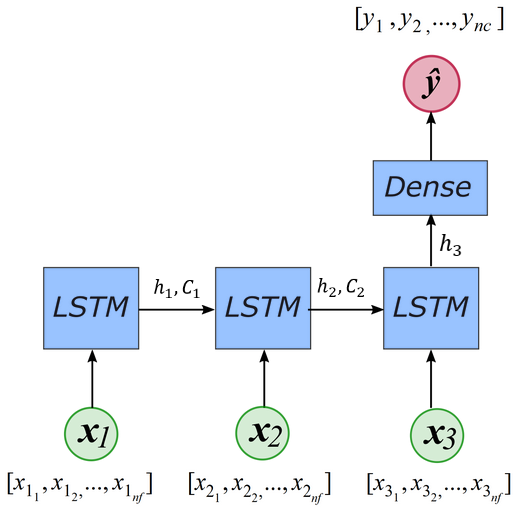

In [ ]:
!pip install scikit-video
!pip install icecream
!pip install -q git+https://github.com/tensorflow/docs
!pip install imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.layers import GlobalAveragePooling2D
from keras import Model
import tensorflow as tf


import skvideo.io
import skvideo.datasets
import glob

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Input
from keras.models import Model
from sklearn.metrics import accuracy_score, f1_score
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import time



import imageio
from tensorflow_docs.vis import embed
import cv2
import os
%matplotlib inline
import pathlib

import tensorflow

tensorflow.random.set_seed(42)
np.random.seed(42)

t0 = time.time()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **<center>Dataset loading and preprocessing</center>**

We will be using the UCF101 action recognition dataset. 4 classes were selected: Basketball, Diving, GolfSwing, Skiing

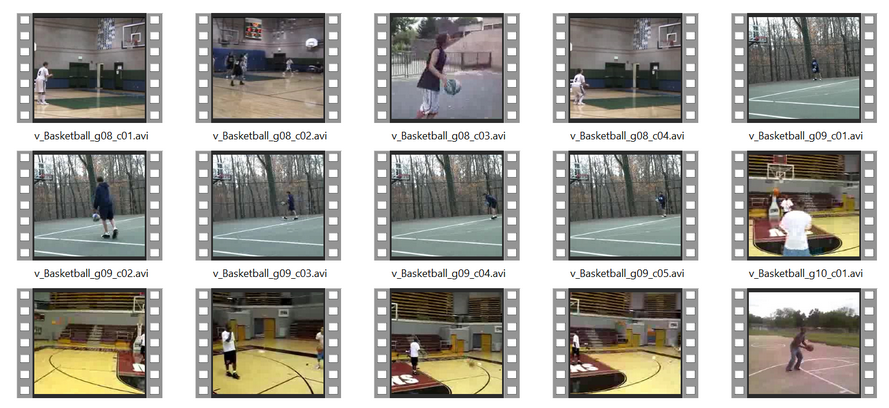

## **<center>Download the videos</center>**



In [ ]:
t0=time.time()
os.getcwd()

path = './Videos'
pathlib.Path(path).mkdir(parents=True, exist_ok=True)
os.chdir(path)


In [ ]:
!gdown --i 1_qRKzrIVJ8vHVpM9lMuvrcjzUzp_9NuY
!unzip -n /content/gdrive/My\ Drive/RNN_exercise/Videos.zip -d .

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_qRKzrIVJ8vHVpM9lMuvrcjzUzp_9NuY
To: /content/Videos/Videos.zip
100% 208M/208M [00:01<00:00, 136MB/s]
Archive:  /content/gdrive/My Drive/RNN_exercise/Videos.zip
   creating: ./Videos/
   creating: ./Videos/Testing/
   creating: ./Videos/Testing/Basketball/
  inflating: ./Videos/Testing/Basketball/v_Basketball_g01_c01.avi  
  inflating: ./Videos/Testing/Basketball/v_Basketball_g01_c02.avi  
  inflating: ./Videos/Testing/Basketball/v_Basketball_g01_c03.avi  
  inflating: ./Videos/Testing/Basketball/v_Basketball_g01_c04.avi  
  inflating: ./Videos/Testing/Basketball/v_Basketball_g01_c05.avi  
  inflating: ./Videos/Testing/Basketball/v_Basketball_g01_c06.avi  
  inflating: ./Videos/Testing/Basketball/v_Basketball_g01_c07.avi 

In [ ]:
!ls
!ls Videos/Testing
!ls Videos/Training


sample_data
ls: cannot access 'Videos/Testing': No such file or directory
ls: cannot access 'Videos/Training': No such file or directory


## **<center>Prepare the dataset</center>**
* Train test split
* Define the frame number = 40
* Convert labels to one-hot encoding



In [ ]:

# This function assigns the corresponding class labels to each sample
def dataset_build(data_path, classes, set_):
    set_file_count = len(glob.glob(data_path+set_+'/**/*.avi',recursive=True))
    print(set_+" file count:",set_file_count)
    X_filenames=[]
    Y=np.zeros(set_file_count)
    sample_id=0
    for clss_name,clss_idx in zip(classes,range(len(classes))):
        clss_file_list=glob.glob(data_path+set_+'/'+clss_name+'/*.avi')
        X_filenames+=clss_file_list
        print("debug: sample_id={}, len(clss_file_list)={}".format(sample_id,clss_file_list))
        Y[sample_id:sample_id+len(clss_file_list)]=clss_idx # Assing labels to samples from each class
        sample_id+=len(clss_file_list)
    return X_filenames, Y

data_path='Videos/'
classes=['Basketball','Diving','GolfSwing','Skiing']
t_len, feature_len, class_n = 40, 512, len(classes)
X_filenames_train,Y_train=dataset_build(data_path, classes, set_='Testing')
X_filenames_test,Y_test=dataset_build(data_path, classes, set_='Training')

print("Train class unique values",np.unique(Y_train,return_counts=True))
print("Test class unique values",np.unique(Y_test,return_counts=True))
print("Classes:",classes)


Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)



Testing file count: 159
debug: sample_id=0, len(clss_file_list)=['Videos/Testing/Basketball/v_Basketball_g01_c07.avi', 'Videos/Testing/Basketball/v_Basketball_g06_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g06_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g05_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g04_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c05.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c02.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c06.avi', 'Videos/Testing/Basketball/v_Basketball_g03_c03.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c06.avi', 'Videos/Testing/Basketball/v_Basketball_g06_c04.avi', 'Videos/Testing/Basketball/v_Basketball_g02_c01.avi', 'Videos/Testing/Basketball/v_Basketball_g01_c04.avi', 'Videos/Testing/B

# **<center>Define the pre-trained model and extract features</center>**


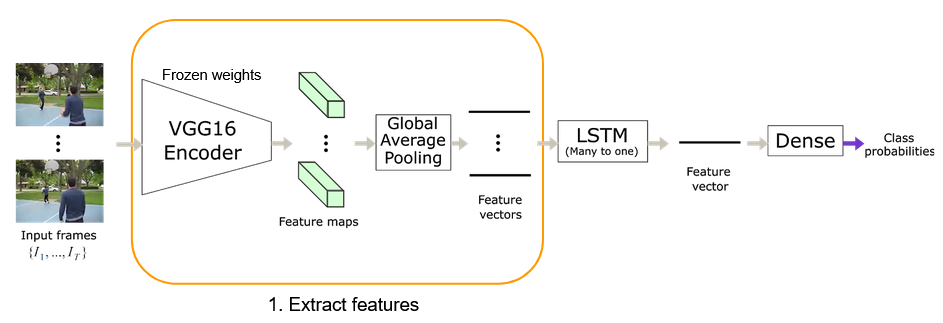

## Specify the pre-trained encoder architecture

In [ ]:
def get_model():
    video_shape = (224, 224, 3)

    model = Sequential()

    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=video_shape)
    vgg16.trainable = False

    model.add(vgg16)
    model.add(GlobalAveragePooling2D())

    return model

def extract_features(video_path, model, num_frames=40):

    '''
    1. Loads a video as videogen
    2. Extracts features from VGG16 CNN encoder model for each frame in vgg16_feature

    Arguments

    video_path: path to the video file.
    model: VGG16 CNN encoder model.
    num_frames: number of frames in the video. Each video has 40 frames.

    Return value

    Returned value is of shape (t_len, feature_len)
    '''
    # Load the video
    if video_path is None:
        video_path = skvideo.datasets.bigbuckbunny()
    videogen = skvideo.io.vreader(video_path, num_frames=num_frames)


    # Extract features for each frame
    frames = np.array([frame[:224,:224] for frame in videogen])
    frames = preprocess_input(frames) # Covert from RGB to BGR. Then subtract ImageNet mean value
    features = model.predict(frames)

    return np.squeeze(features)

cnnModel = get_model()

58889256/58889256 [==============================] - 0s 0us/step


## Extract features from the pre-trained model

In [ ]:
# Creates a function for extracting features for all videos training and testing
# Features extracted from CNN correspond to X_train and X_test variables

import pdb

def extract_features_from_set(cnnModel, X_filenames, X):
    for i, filename in enumerate(X_filenames):
        X[i] = extract_features(filename, cnnModel)

    return X

load_pretrained_features_flag = False
pretrained_features_filename = path + '/pretrained_features.npz'

if load_pretrained_features_flag == False:
    X_train = np.zeros((Y_train.shape[0],t_len,feature_len))
    X_test = np.zeros((Y_test.shape[0],t_len,feature_len))
    print("X train shape:{}, X test shape:{}".format(X_train.shape,X_test.shape))

    print("Before extract features execution time: ",time.time()-t0)

    X_train = extract_features_from_set(cnnModel, X_filenames_train, X_train)
    print("Train features extracted")
    print(X_train.shape,X_test.shape)
    X_test = extract_features_from_set(cnnModel, X_filenames_test, X_test)
    print("Test features extracted")

    # Save extracted CNN features
    np.savez(pretrained_features_filename, x_test = X_test, x_train = X_train)
else:
    # CNN feature extraction takes about 25 minutes.
    # After extracting for the first time, load the CNN features from file
    data = np.load(pretrained_features_filename)

    X_train = data['x_train']
    X_test = data['x_test']

print("X_train.shape={}, Y_train.shape={}".format(X_train.shape,Y_train.shape))
print("X_test.shape={}, Y_test.shape={}".format(X_test.shape,Y_test.shape))


X train shape:(159, 40, 512), X test shape:(399, 40, 512)
Before extract features execution time:  81.42486190795898
2/2 [==============================] - 0s 102ms/step
Train features extracted
(159, 40, 512) (399, 40, 512)
2/2 [==============================] - 0s 111ms/step
Test features extracted
X_train.shape=(159, 40, 512), Y_train.shape=(159, 4)
X_test.shape=(399, 40, 512), Y_test.shape=(399, 4)


# **<center>Define the trainable LSTM model</center>**
Define the LSTM block, and the final Dense layer with softmax. Also, define the training loss and optimizer

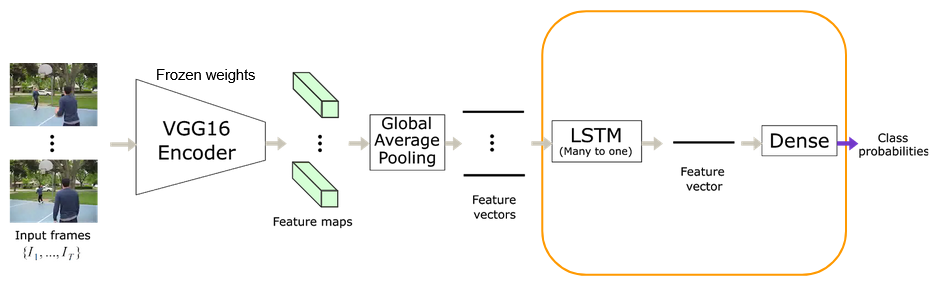

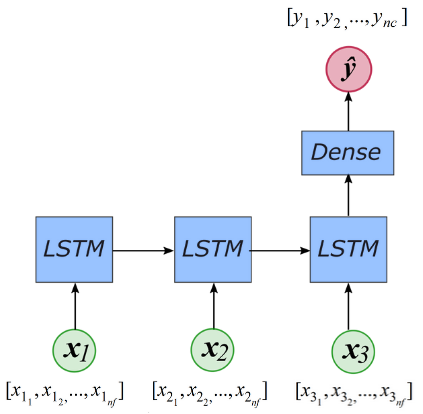

In [ ]:
print("Input shape: ({}, {})".format(t_len, feature_len))

batch_size = 64

model = Sequential()

model.add(LSTM(40))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build((batch_size, t_len, feature_len))
model.summary()

print("Before fit execution time: ",time.time()-t0)


Input shape: (40, 512)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (64, 40)                  88480     
                                                                 
 dense (Dense)               (64, 4)                   164       
                                                                 
Total params: 88644 (346.27 KB)
Trainable params: 88644 (346.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Before fit execution time:  401.206650018692


# **<center>Train</center>**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, Y_train, epochs=1000, batch_size=batch_size, validation_split=0.1, verbose=2, callbacks=[early_stopping])

print("execution time: ",time.time()-t0)

Epoch 1/1000
3/3 - 7s - loss: 1.2913 - accuracy: 0.4056 - val_loss: 1.3406 - val_accuracy: 0.3125 - 7s/epoch - 2s/step
Epoch 2/1000
3/3 - 0s - loss: 0.6941 - accuracy: 0.8252 - val_loss: 1.0361 - val_accuracy: 0.6875 - 116ms/epoch - 39ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.4576 - accuracy: 0.9371 - val_loss: 0.6975 - val_accuracy: 0.7500 - 98ms/epoch - 33ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.3243 - accuracy: 0.9790 - val_loss: 0.5042 - val_accuracy: 0.9375 - 50ms/epoch - 17ms/step
Epoch 5/1000
3/3 - 0s - loss: 0.2467 - accuracy: 0.9860 - val_loss: 0.4181 - val_accuracy: 0.8750 - 57ms/epoch - 19ms/step
Epoch 6/1000
3/3 - 0s - loss: 0.1955 - accuracy: 0.9860 - val_loss: 0.3759 - val_accuracy: 0.8750 - 52ms/epoch - 17ms/step
Epoch 7/1000
3/3 - 0s - loss: 0.1545 - accuracy: 0.9860 - val_loss: 0.3412 - val_accuracy: 0.9375 - 50ms/epoch - 17ms/step
Epoch 8/1000
3/3 - 0s - loss: 0.1290 - accuracy: 0.9860 - val_loss: 0.3228 - val_accuracy: 0.9375 - 53ms/epoch - 18ms/step
Epoch 9/1000
3/3 - 


# **<center>Evaluate the model</center>**
Predict and estimate test set accuracy (accuracy_score)

In [ ]:
pred_test = model.predict(X_test)

Y_test_ = Y_test.argmax(axis=-1)
pred_test_ = pred_test.argmax(axis=-1)

accuracy = accuracy_score(Y_test_, pred_test_)
f1_scores = f1_score(Y_test_, pred_test_, average=None)
average_f1 = f1_score(Y_test_, pred_test_, average='weighted')

print(f"Accuracy      = {accuracy:.2%}")
print(f"F1 Basketball = {f1_scores[0]:.2%}")
print(f"   Diving     = {f1_scores[1]:.2%}")
print(f"   GolfSwing  = {f1_scores[2]:.2%}")
print(f"   Skiing     = {f1_scores[3]:.2%}")
print(f"   Average    = {average_f1:.2%}")

13/13 [==============================] - 0s 4ms/step
Accuracy      = 85.71%
F1 Basketball = 72.92%
   Diving     = 89.00%
   GolfSwing  = 88.78%
   Skiing     = 91.67%
   Average    = 85.59%


## **<center>Sample test predictions</center>**
Plot test predictions for the final model

(113, 224, 224, 3)
1/1 [==============================] - 0s 87ms/step
Classification result for video ID 102: Diving



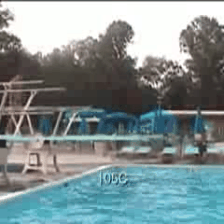

In [ ]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')


idx = np.random.randint(0, X_test.shape[0]) # Random ID from test set
sample_video = load_video(X_filenames_test[idx])

print(sample_video.shape)
sample_video = sample_video[:100]

# Make prediction on sample test video
prediction = model.predict(np.expand_dims(X_test[idx], axis=0))
prediction = np.squeeze(prediction)

print("Classification result for video ID {}: {}".format(idx, classes[prediction.argmax(axis=0)]))


# Display sample test video
to_gif(sample_video)

In [ ]:
print(time.time() - t0)

438.8813102245331


# **<center>Experiments</center>**

1. Use different LSTM internal units: 50, 100, 200, 500
2. Replace LSTM with GRU (count number of parameters)
3. Use a deep LSTM. Two stacked LSTM layers: The output of the first LSTM goes to the input of the second LSTM (Hint: The first LSTM should be configured as "N-to-N" using the parameter "return_sequences")

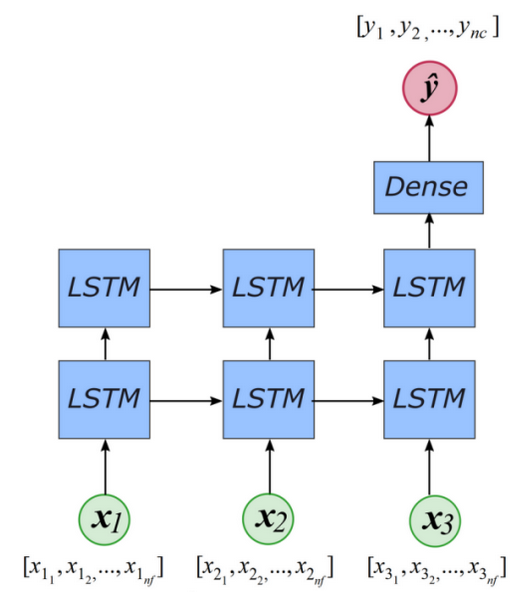

# Report

Homework report: The report must contain:

1.    A link to the notebook with your code.
2.    A PDF file reporting your experiments, including the results in the form of the table, and discussing the results

Fill in your results in the following information in a table:


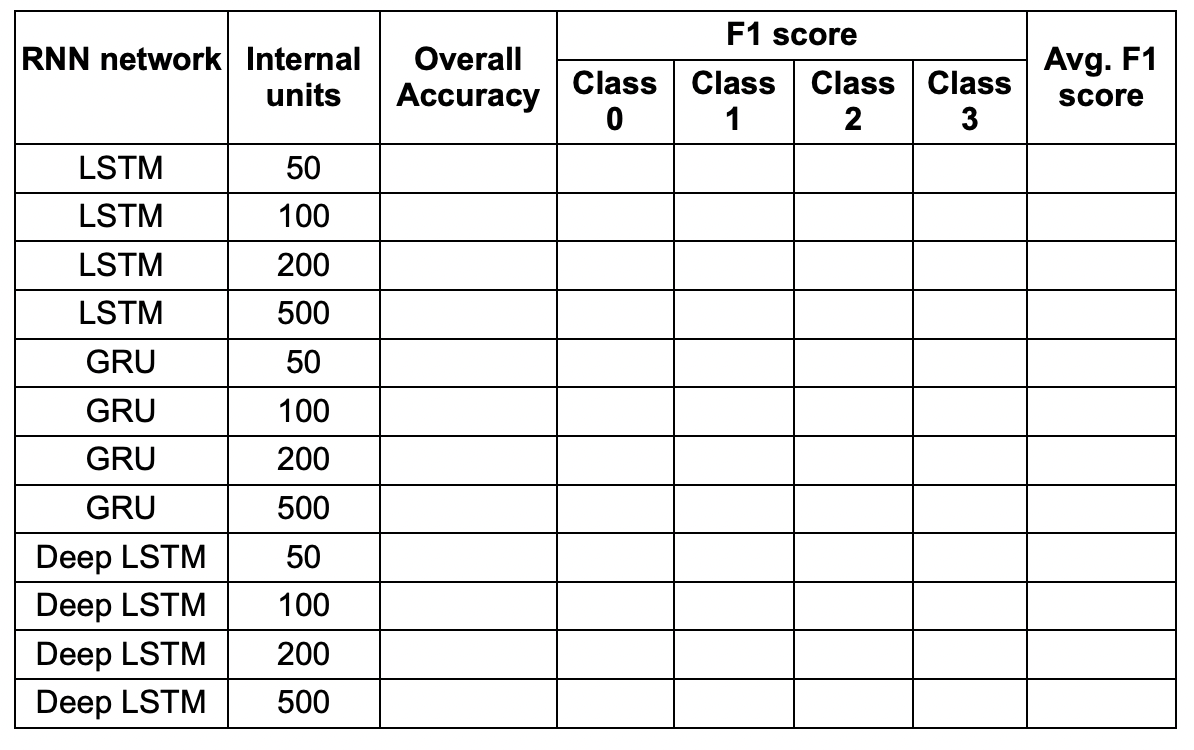

# Experimentos




In [ ]:
def experiment_lstm(internal_units):
    model = Sequential()
    model.add(LSTM(internal_units, input_shape=(t_len, feature_len)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def experiment_GRU(internal_units):
    model = Sequential()
    model.add(GRU(internal_units, input_shape=(t_len, feature_len)))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def experiment_deep_lstm(internal_units):
    model = Sequential()
    model.add(LSTM(internal_units, return_sequences=True, input_shape=(t_len, feature_len)))
    model.add(LSTM(internal_units))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def train_and_test(model):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    time_start = time.time()
    model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, validation_split=0.1, verbose=2, callbacks=[early_stopping])
    ex_time = time.time()-time_start
    pred_test = model.predict(X_test)
    Y_test_ = Y_test.argmax(axis=-1)
    pred_test_ = pred_test.argmax(axis=-1)

    accuracy = accuracy_score(Y_test_, pred_test_)
    f1_scores = f1_score(Y_test_, pred_test_, average=None)
    average_f1 = f1_score(Y_test_, pred_test_, average='weighted')

    return accuracy, f1_scores, average_f1, ex_time

internal_units = [50, 100, 200, 500]

lstm_results = []
gru_results = []
deep_lstm_results = []

for units in internal_units:
    lstm_results.append(train_and_test(experiment_lstm(units)))
    gru_results.append(train_and_test(experiment_GRU(units)))
    deep_lstm_results.append(train_and_test(experiment_deep_lstm(units)))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                112600    
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 112804 (440.64 KB)
Trainable params: 112804 (440.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
3/3 - 2s - loss: 1.2207 - accuracy: 0.4336 - val_loss: 1.4526 - val_accuracy: 0.1875 - 2s/epoch - 812ms/step
Epoch 2/100
3/3 - 0s - loss: 0.7319 - accuracy: 0.8112 - val_loss: 1.2059 - val_accuracy: 0.6250 - 56ms/epoch - 19ms/step
Epoch 3/100
3/3 - 0s - loss: 0.5266 - accuracy: 0.9021 - val_loss: 0.9676 - val_accuracy: 0.8125 - 54ms/epoch - 18ms/step
Epoch 4/100
3/3 - 0s - loss: 0.3556 - accurac

In [ ]:
accuracy, f1_scores, average_f1, exec_time = lstm_results[0]

print("LSTM 50")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2%}")
print(f"  Time: ={exec_time:.5}")

LSTM 50
  Accuracy      = 90.73%
  F1 Basketball = 81.97%
    Diving      = 93.95%
    GolfSwing   = 90.48%
    Skiing      = 95.79%
    Average     = 90.55%
  Time: =6.2713


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = lstm_results[1]

print("LSTM 100")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2%}")
print(f"  Time: ={exec_time:.5}")

LSTM 100
  Accuracy      = 90.98%
  F1 Basketball = 81.61%
    Diving      = 91.96%
    GolfSwing   = 94.23%
    Skiing      = 94.79%
    Average     = 90.64%
  Time: =11.77


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = lstm_results[2]

print("LSTM 200")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2%}")
print(f"  Time: ={exec_time:.5}")

LSTM 200
  Accuracy      = 93.48%
  F1 Basketball = 87.70%
    Diving      = 94.79%
    GolfSwing   = 96.04%
    Skiing      = 94.95%
    Average     = 93.38%
  Time: =4.7539


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = lstm_results[3]

print("LSTM 500")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2}")
print(f"  Time: ={exec_time:.5}")

LSTM 500
  Accuracy      = 93.98%
  F1 Basketball = 88.54%
    Diving      = 94.84%
    GolfSwing   = 97.00%
    Skiing      = 95.34%
    Average     = 0.94
  Time: =11.286


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = gru_results[0]

print("GRU 50")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2}")
print(f"  Time: ={exec_time:.5}")

GRU 50
  Accuracy      = 90.98%
  F1 Basketball = 82.87%
    Diving      = 91.74%
    GolfSwing   = 92.38%
    Skiing      = 96.30%
    Average     = 0.91
  Time: =12.469


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = gru_results[1]

print("GRU 100")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2%}")
print(f"  Time: ={exec_time:.5}")

GRU 100
  Accuracy      = 91.98%
  F1 Basketball = 82.98%
    Diving      = 94.01%
    GolfSwing   = 95.57%
    Skiing      = 94.74%
    Average     = 91.84%
  Time: =3.3069


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = gru_results[2]

print("GRU 200")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2%}")
print(f"  Time: ={exec_time:.5}")

GRU 200
  Accuracy      = 93.48%
  F1 Basketball = 86.34%
    Diving      = 94.12%
    GolfSwing   = 97.00%
    Skiing      = 95.88%
    Average     = 93.33%
  Time: =12.094


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = gru_results[3]

print("GRU 500")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2%}")
print(f"  Time: ={exec_time:.5}")

GRU 500
  Accuracy      = 86.97%
  F1 Basketball = 73.94%
    Diving      = 91.74%
    GolfSwing   = 85.84%
    Skiing      = 94.18%
    Average     = 86.43%
  Time: =3.3906


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = deep_lstm_results[0]

print("Deep LSTM 50")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2%}")
print(f"  Time: ={exec_time:.5}")

Deep LSTM 50
  Accuracy      = 90.23%
  F1 Basketball = 82.42%
    Diving      = 91.24%
    GolfSwing   = 92.93%
    Skiing      = 93.53%
    Average     = 90.02%
  Time: =14.747


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = deep_lstm_results[1]

print("Deep LSTM 100")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2%}")
print(f"  Time: ={exec_time:.5}")

Deep LSTM 100
  Accuracy      = 92.23%
  F1 Basketball = 85.26%
    Diving      = 94.84%
    GolfSwing   = 93.94%
    Skiing      = 94.42%
    Average     = 92.14%
  Time: =12.954


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = deep_lstm_results[2]

print("Deep LSTM 200")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2%}")
print(f"  Time: ={exec_time:.5}")

Deep LSTM 200
  Accuracy      = 89.47%
  F1 Basketball = 80.65%
    Diving      = 94.34%
    GolfSwing   = 90.16%
    Skiing      = 91.79%
    Average     = 89.29%
  Time: =13.844


In [ ]:
accuracy, f1_scores, average_f1,  exec_time = deep_lstm_results[3]

print("Deep LSTM 500")
print(f"  Accuracy      = {accuracy:.2%}")
print(f"  F1 Basketball = {f1_scores[0]:.2%}")
print(f"    Diving      = {f1_scores[1]:.2%}")
print(f"    GolfSwing   = {f1_scores[2]:.2%}")
print(f"    Skiing      = {f1_scores[3]:.2%}")
print(f"    Average     = {average_f1:.2%}")
print(f"  Time: ={exec_time:.5}")

Deep LSTM 500
  Accuracy      = 89.47%
  F1 Basketball = 76.92%
    Diving      = 94.84%
    GolfSwing   = 91.43%
    Skiing      = 92.23%
    Average     = 88.92%
  Time: =23.156
